# [GA360] On-site behaviour

## Initiate connection

In [1]:
# Import libraries
import pandas as pd
from google.cloud import bigquery

# Launch BigQuery client from the JSON credentials file
bq_client = bigquery.Client.from_service_account_json('../bigquery_creds.json')

# Helper function for queries to be returned as a Dataframe
def bquery(sql):
    return bq_client.query(sql).to_dataframe()

## Conversion rate by weekday and hour

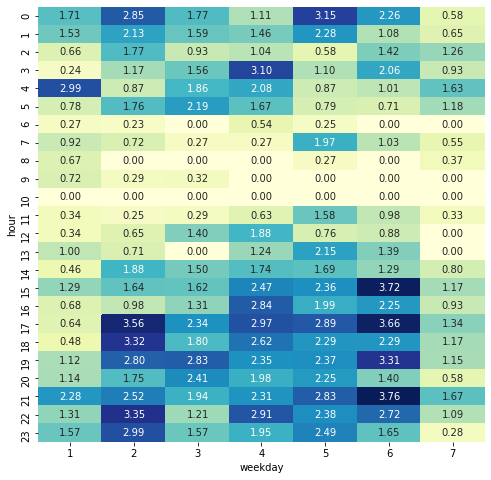

In [2]:
# Conversion rate by weekday and hour
sql = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE("%Y%m%d", date)) AS weekday,
    EXTRACT(HOUR FROM PARSE_TIMESTAMP("%s", CAST(visitStartTime AS STRING))) AS hour,
    100*SUM(totals.transactions)/SUM(totals.visits) AS conv_rate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
GROUP BY 1,2
"""
slots = bquery(sql)

# Plot as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.heatmap(
    slots.pivot(index='hour', columns='weekday', values='conv_rate').fillna(0), 
    cmap="YlGnBu", annot=True, fmt='.2f', cbar=False);

## How many pageviews before reaching a Destination Goal

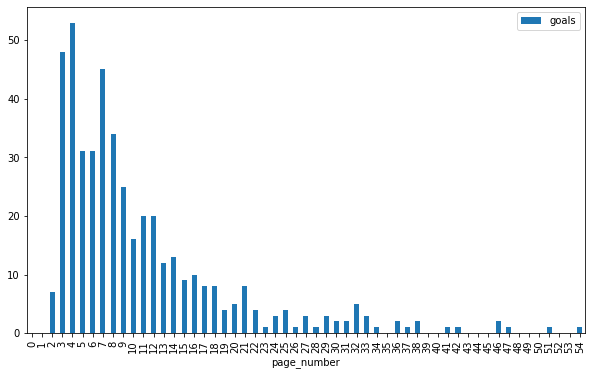

In [3]:
# Number of pages viewed in a session before reaching a Goal (destination page)
sql = """
WITH sub1 AS (
    SELECT 
        CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
        -- Window function to compute rank of each Page viewed in a session
        RANK() OVER (PARTITION BY fullVisitorId, visitId ORDER BY hits.hitNumber) AS page_number,
        hits.page.pagePath AS page
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
        -- Filter on Pages only, we don't want all Hits types
        AND hits.type = 'PAGE'
    GROUP BY fullVisitorId, visitId, hits.hitNumber, page
)

SELECT 
    page_number,
    COUNT(*) AS goals
FROM sub1
-- Filter on the destination page associated with a Goal
WHERE page = '/registersuccess.html'
GROUP BY 1
ORDER BY 1
"""
goals_pages = bquery(sql)

# Plot distribution
(
    goals_pages
    .set_index('page_number')
    .reindex(list(range(0, max(goals_pages['page_number'])+1)))
    .plot(kind='bar', figsize=(10,6))
);